In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'category_6_mod_data_common_words'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [10]:
all_data = pickle.load(open("data/en_train_fixed_1.pkl", "rb" ))
all_data_sentence_index = all_data.set_index('sentence_id')

In [5]:
all_data.sample(2)

,sentence_id,token_id,class,before,after,class_org
8886826,671605,6,NOT_CHANGED,Congregation,Congregation,PLAIN
2792824,216189,11,NOT_CHANGED,),),PUNCT


In [6]:
categories_all = all_data["class"].unique()
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['NOT_CHANGED' 'NUMBERS' 'LETTERS' 'PLAIN' 'VERBATIM' 'ELECTRONIC']
6


### Utils stuff

In [11]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


In [5]:
common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

8192

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', '.', ',', 'the', '"', 'of']

### More balanced sample

In [6]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

In [7]:
i = 0
arr = []
for w in common_words:
    if w in wv_idx:
        i += 1
    else:
        arr.append(w)

In [11]:
i/len(common_words)

0.991943359375

In [15]:
all_data.groupby("class")["class"].count()

class
ELECTRONIC        4964
LETTERS         152986
NOT_CHANGED    9258648
NUMBERS         448172
PLAIN            36472
VERBATIM         16950
Name: class, dtype: int64

In [16]:
balanced_data_classes_select = list(all_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_length = 0
def balanced_data_randomize(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_accessed_counter = 0

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_accessed_counter/balanced_data_length > 0.2:
        balanced_data_randomize()
    balanced_data_last_sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    return balanced_data_last_sample
    
balanced_data_randomize()

In [17]:
balanced_data.groupby("class")["class"].count()

class
ELECTRONIC      4964
LETTERS        20000
NOT_CHANGED    20000
NUMBERS        20000
PLAIN          20000
VERBATIM       16950
Name: class, dtype: int64

### Samples

In [131]:
def get_random_sample():
    sample_row = balanced_data_sample_row()
    sentence_id = sample_row['class']

    rows = all_data_sentence_index.loc[sample_row['sentence_id']]
    befores = list(rows.before)
    #befores = np.concatenate([simple_tokeniser(w) for w in befores])
        
    token_id_idx = list(rows['token_id']).index(sample_row['token_id'])
    befores[token_id_idx] = SAMPLE_WORD_TOKEN
    
    return sample_row['before'], sample_row['after'], sample_row['class'], befores
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_class, ':', s_bef, '->', s_aft)
    print(' '.join(s_sentence))
    print(s_sentence)
    wt = words_to_tensor(list(s_sentence), common_words_index)
    print(' '.join([common_words[w] for w in wt.topk(1)[1][0].numpy()[:,0]]))
    
    wt_new = np.concatenate([simple_tokeniser(w) for w in list(s_sentence)])
    wt_new = words_to_tensor(wt_new, common_words_index)
    print(' '.join([common_words[w] for w in wt_new.topk(1)[1][0].numpy()[:,0]]))            
    
    print(wt.shape)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp = tmp()

PLAIN : metres -> meters
Kebnekaise is Sweden's and Sapmi's highest mountain at 2,104 <SAMPLE> above mean sea level .
['Kebnekaise', 'is', "Sweden's", 'and', "Sapmi's", 'highest', 'mountain', 'at', '2,104', '<SAMPLE>', 'above', 'mean', 'sea', 'level', '.']
<UNK> is <UNK> and <UNK> highest mountain at <0000> <SAMPLE> above mean sea level . <EOS>
<UNK> is sweden 's and <UNK> 's highest mountain at 2 , 104 <UNK> above mean sea level . <EOS>
torch.Size([1, 16, 8192])
torch.Size([1, 7, 104])


In [85]:
tmp.topk(1)[1][0]

array([  41,    6,   46,    5, 2711,   13,    2,    4,    3,   14,    5,
          0])

In [95]:
np.concatenate([[1], [2,3 ]])

array([1, 2, 3])

# Model

In [20]:
class CategorizeRNN(nn.Module):
    def __init__(self, output_size, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_dropout=0, chars_dropout=0, words_layers=1, chars_layers=1):
        super(CategorizeRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 dropout=words_dropout, batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                 dropout=chars_dropout, batch_first=True, bidirectional=True)
        
        self.lin_output = nn.Linear(words_hidden_size+chars_hidden_size, output_size)
        
    def forward(self, words_tensor, string_tensor, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(words_tensor, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        output = torch.cat((output_words, output_chars), 1)
        
        #output = self.lin_1(output)
        output = self.lin_output(output)
        output = F.log_softmax(output)
        
        return output

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))

In [22]:
model = CategorizeRNN(len(categories_all), 
                      words_input_size=len(common_words), chars_input_size=len(chars_normal),
                      words_hidden_size=128, chars_hidden_size=128,
                      words_layers=2, chars_layers=2,
                      words_dropout=0.2, chars_dropout=0.2)
model = model.cuda()

model_training = ModelTraining(MODEL_SAVE_PATH, [model])

model

Save path: data/models/category_6_mod_data_common_words


CategorizeRNN (
  (rnn_words): LSTM(8192, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (rnn_chars): LSTM(104, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (lin_output): Linear (256 -> 6)
)

### Accuracy

In [25]:
def test_model_single_sample(model):
    s_bef, s_aft, s_class, s_sentence = sample = get_random_sample()
    
    words_t = words_to_tensor(list(s_sentence), common_words_index)
    words_t = Variable(words_t).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    output = model(words_t, string_t)
    guess = category_from_output(output, categories_all)

    return output, guess, (s_class, categories_index[s_class]), sample
    
tmp = test_model_single_sample(model)
tmp

(Variable containing:
 -1.7564 -1.7678 -1.8122 -1.8200 -1.8326 -1.7643
 [torch.cuda.FloatTensor of size 1x6 (GPU 0)],
 ('NOT_CHANGED', 0),
 ('LETTERS', 2),
 ('C. C.',
  'c c',
  'LETTERS',
  ['Edward', '<SAMPLE>', 'Stanford', '(', '1862', ')', '.']))

In [33]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(model, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        m = torch.nn.functional.softmax(output).max().data[0]
        print("{:>11} -> {:>11} ({:0.3}) || {:>8} -> {} == {}".format(s_class, predict[0], m, s_bef, s_aft, ' '.join(s_sentence), ))

In [35]:
print_local_wrong_predictions(max_results=1)

      PLAIN -> NOT_CHANGED (0.172) ||        - -> to == It aired at 2pm <SAMPLE> 7pm on KRLD- FM , " The Fan " 105.3 , in dallas texas .
NOT_CHANGED ->  ELECTRONIC (0.173) ||      The -> The == <SAMPLE> holiday crowd of 1,297 at Hess Stadium witnessed the last professional baseball game in Allentown for 37 years .


### Training

In [36]:
def train(model, s_category, s_sentence, s_bef, loss_function, optimizer):
    
    category_tensor = Variable(torch.LongTensor([categories_index[s_category]])).cuda()
    
    words_t = words_to_tensor(list(s_sentence), common_words_index)
    words_t = Variable(words_t).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    output = model(words_t, string_t)
    loss = loss_function(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0]

In [37]:
def train_iterations(n_iters=100000, lr=0.001, print_every=10000, plot_every=1000):

    start = time.time()
    model.train()

    current_loss = 0
    current_loss_iter = 0

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(model=model, s_category=s_class, s_sentence=s_sentence,
                             s_bef=s_bef, optimizer=optimizer, loss_function=loss_function)

        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            guess, guess_i = category_from_output(result, categories_all)
            correct = '✓' if guess == s_class else "✗ {}".format(s_class)
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({})".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, guess, correct))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(model, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [38]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

    10  18% (   0m 0s)   1.788   |   1.83: # -> NOT_CHANGED (✗ VERBATIM)
Saved model to data/models/category_6_mod_data_common_words/10_(CategorizeRNN)
Accuracy: 19.57% (    1957/   10000)
    19  36% (  0m 31s)   1.785   |   1.73: band -> NOT_CHANGED (✓)
    28  54% (  0m 31s)   1.788   |   1.76: 1 July 2010 -> NOT_CHANGED (✗ NUMBERS)
    37  72% (  0m 31s)   1.789   |   1.83: & -> NOT_CHANGED (✗ VERBATIM)
    46  90% (  0m 31s)   1.787   |   1.77: 2002 -> NOT_CHANGED (✗ NUMBERS)


In [39]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   551  53% (   0m 5s)   1.761   |   1.73: dr -> NUMBERS (✗ PLAIN)


In [40]:
train_iterations(n_iters=10000, lr=0.0001, print_every=1000)

  2000  10% (   0m 9s)   1.369   |   0.49: 2009 -> NUMBERS (✓)
  3000  20% (  0m 19s)   1.017   |   0.09: August 23, 1998 -> NUMBERS (✓)
  4000  30% (  0m 28s)   0.801   |   0.22: www.trillian.im -> ELECTRONIC (✓)
  5000  40% (  0m 37s)   0.674   |   1.12: - -> PLAIN (✓)
  6000  50% (  0m 47s)   0.574   |   0.01: 1985 -> NUMBERS (✓)
  7000  60% (  0m 57s)   0.522   |   0.01: 978-1-909740-64-8 -> NUMBERS (✓)
  8000  70% (   1m 9s)   0.503   |   1.10: ) -> PLAIN (✗ NOT_CHANGED)
  9000  80% (  1m 19s)   0.443   |   0.05: # -> VERBATIM (✓)
 10000  90% (  1m 29s)   0.419   |   1.57: Quebec -> ELECTRONIC (✗ NOT_CHANGED)
 11000 100% (  1m 40s)   0.404   |   0.03: D. R. -> LETTERS (✓)


In [41]:
train_iterations(n_iters=89000, print_every=10000)

 21000  11% (  1m 41s)   0.242   |   1.32: OK -> LETTERS (✗ PLAIN)
 31000  22% (  3m 23s)   0.178   |   0.02: brewery -> NOT_CHANGED (✓)
 41000  34% (   5m 4s)   0.167   |   0.03: US -> LETTERS (✓)
Saved model to data/models/category_6_mod_data_common_words/50000_(CategorizeRNN)
Accuracy: 96.36% (    9636/   10000)
 51000  45% (  7m 17s)   0.092   |   0.01: vol -> PLAIN (✓)
 61000  56% (  8m 58s)   0.102   |   0.00: D. -> LETTERS (✓)
 71000  67% ( 10m 39s)   0.090   |   0.00: K.J. -> LETTERS (✓)
 81000  79% ( 12m 21s)   0.079   |   0.02: SS -> LETTERS (✓)
 91000  90% (  14m 3s)   0.087   |   0.00: E. -> LETTERS (✓)
Saved model to data/models/category_6_mod_data_common_words/100000_(CategorizeRNN)
Accuracy: 97.78% (    9778/   10000)


In [42]:
print_local_wrong_predictions()

    LETTERS -> NOT_CHANGED (0.431) ||     Ipes -> i p e's == " Lavras , Terra dos <SAMPLE> e das Escolas . "
    LETTERS -> NOT_CHANGED (0.621) ||     pela -> p e l a == " Boletim Informativo Diario Eletronico ( BID E ) Relacao <SAMPLE> data 02/03/2011 " .
    LETTERS -> NOT_CHANGED (0.912) ||     Qwan -> q w a n == He got eaten by <SAMPLE> when fighting him .
      PLAIN ->     LETTERS (0.985) || U.N.C.L.E. -> uncle == He also played Nigel Pennington Smythe in the TV reunion film Return of the Man from <SAMPLE> ( 1983 ) .
    LETTERS -> NOT_CHANGED (0.994) ||     Lwow -> l w o w == Elisabeth was in <SAMPLE> , too .
    LETTERS -> NOT_CHANGED (0.734) ||     Shus -> s h u's == Nixon and Roper's third album , 1987's Bo Day <SAMPLE> !
      PLAIN ->     LETTERS (0.99) ||      BBQ -> barbeque == The all inclusive experience will include game tickets , patio style seating , and a 90 - minute all you can eat <SAMPLE> buffet .
NOT_CHANGED ->     LETTERS (0.506) ||      gal -> gal == With full

In [43]:
train_iterations(n_iters=100000, print_every=10000)

110000  10% (  1m 43s)   0.063   |   0.00: PlanetMath.org -> ELECTRONIC (✓)
120000  20% (  3m 16s)   0.080   |   0.07: : -> PLAIN (✓)
130000  30% (  4m 49s)   0.081   |   0.00: IFC -> LETTERS (✓)
140000  40% (  6m 22s)   0.062   |   0.00: the -> NOT_CHANGED (✓)
150000  50% (   8m 0s)   0.047   |   0.00: & -> VERBATIM (✓)
Saved model to data/models/category_6_mod_data_common_words/150000_(CategorizeRNN)
Accuracy: 98.15% (    9815/   10000)
160000  60% ( 10m 14s)   0.058   |   0.00: In -> NOT_CHANGED (✓)
170000  70% ( 11m 50s)   0.049   |   0.00: . -> NOT_CHANGED (✓)
180000  80% ( 13m 26s)   0.048   |   0.00: vol -> PLAIN (✓)
190000  90% (  15m 2s)   0.073   |   0.00: 2 -> NUMBERS (✓)
200000 100% ( 16m 36s)   0.049   |   0.00: 2001-12-05 -> NUMBERS (✓)
Saved model to data/models/category_6_mod_data_common_words/200000_(CategorizeRNN)
Accuracy: 98.67% (    9867/   10000)


In [44]:
print_local_wrong_predictions()

    LETTERS ->       PLAIN (0.811) ||       OR -> o r == Philomath , <SAMPLE> : Bridge Media Group .
    NUMBERS ->     LETTERS (0.866) ||       IV -> the fourth == Shaw MacDuff was made keeper of Inverness Castle , which was a strategic royal castle , by Malcolm <SAMPLE> of Scotland .
NOT_CHANGED ->       PLAIN (0.859) || healthcare -> healthcare == Petra Letang plays <SAMPLE> assistant Adele Effanga and made her first appearance in series 16 on 14 January 2014 .
    LETTERS -> NOT_CHANGED (0.986) ||    Tsayt -> t s a y t == Di <SAMPLE> was founded on the initiative of Nachman Syrkin and other champions of the Poale Zion .
      PLAIN ->     LETTERS (0.517) ||       sr -> senior == The last <SAMPLE> 1 to be equipped with bogies allowing 160 km/h was number 3107 .
NOT_CHANGED ->    VERBATIM (0.993) ||        ม -> ม == Mahidol University Salaya Campus Stadium ( Thai : ส น า ม <SAMPLE> .
    LETTERS -> NOT_CHANGED (0.998) ||    folgt -> f o l g t == " Veh <SAMPLE> auf Meister Magath " ( 

In [49]:
train_iterations(n_iters=100000, lr=0.0001, print_every=10000)

210000  10% (  1m 37s)   0.027   |   0.08: ST -> PLAIN (✓)
220000  20% (  3m 11s)   0.040   |   0.00: C.E. -> LETTERS (✓)
230000  30% (  4m 48s)   0.032   |   0.00: theatre -> PLAIN (✓)
240000  40% (  6m 23s)   0.070   |   0.00: st -> PLAIN (✓)
250000  50% (   8m 2s)   0.056   |   0.00: - -> PLAIN (✓)
Saved model to data/models/category_6_mod_data_common_words/250000_(CategorizeRNN)
Accuracy: 98.79% (    9879/   10000)
260000  60% ( 10m 14s)   0.031   |   0.00: 3,380 -> NUMBERS (✓)
270000  70% ( 11m 51s)   0.032   |   0.00: other -> NOT_CHANGED (✓)
280000  80% ( 13m 30s)   0.046   |   0.00: vol -> PLAIN (✓)
290000  90% (  15m 8s)   0.037   |   0.00: June 27, 2011 -> NUMBERS (✓)
300000 100% ( 16m 46s)   0.018   |   0.00: S.C. -> LETTERS (✓)
Saved model to data/models/category_6_mod_data_common_words/300000_(CategorizeRNN)
Accuracy: 99.01% (    9901/   10000)


In [50]:
print_local_wrong_predictions()

NOT_CHANGED ->     LETTERS (0.503) ||     Knox -> Knox == It was developed by Park Place Productions , North America's largest independent development company owned by Michael <SAMPLE> and Troy Lyndon .
NOT_CHANGED ->     LETTERS (0.471) ||      pre -> pre == The municipality is located in the Veveyse district , at the foot of the Fribourg <SAMPLE> alpine mountains ( Niremont , Les Alpettes ) .
      PLAIN ->     LETTERS (0.417) ||      ave -> avenue == Atkinson Park located on Riverside dr West and Bridge <SAMPLE> is a 6 ( 25,000 m2 ) park .
NOT_CHANGED ->     LETTERS (0.97) ||      I'm -> I'm == David Brown , " Ian Tomlinson : ' See you tomorrow , Barry , if <SAMPLE> still living and breathing ' " , The Times , 9 April 2009 .
    LETTERS -> NOT_CHANGED (0.674) ||      det -> d e t == " Lat <SAMPLE> ratta komma ut " ( in Swedish ) .
    LETTERS -> NOT_CHANGED (0.498) ||     Isan -> i s a n == <SAMPLE> ( sometimes written isan or ISAN ) are an English electronic music duo .
NOT_CHANGED

In [51]:
train_iterations(n_iters=100000, lr=0.001, print_every=10000)

310000  10% (  1m 41s)   0.044   |   0.00: Kilkenny -> NOT_CHANGED (✓)
320000  20% (  3m 19s)   0.051   |   0.00: - -> PLAIN (✓)
330000  30% (  4m 58s)   0.067   |   0.00: DVD -> LETTERS (✓)
340000  40% (  6m 35s)   0.043   |   0.00: - -> PLAIN (✓)
350000  50% (  8m 12s)   0.060   |   1.21: IV -> NUMBERS (✗ LETTERS)
Saved model to data/models/category_6_mod_data_common_words/350000_(CategorizeRNN)
Accuracy: 98.52% (    9852/   10000)
360000  60% ( 10m 24s)   0.038   |   0.00: Y. -> LETTERS (✓)
370000  70% (  12m 1s)   0.037   |   0.00: 18 -> NUMBERS (✓)
380000  80% ( 13m 41s)   0.052   |   0.00: is -> NOT_CHANGED (✓)
390000  90% ( 15m 20s)   0.035   |   0.00: Fillet -> NOT_CHANGED (✓)
400000 100% ( 16m 58s)   0.014   |   0.00: UK -> LETTERS (✓)
Saved model to data/models/category_6_mod_data_common_words/400000_(CategorizeRNN)
Accuracy: 98.86% (    9886/   10000)


In [52]:
print_local_wrong_predictions()

    LETTERS -> NOT_CHANGED (0.813) ||     Junr -> j u n r == One of the clauses of this Act appointed Lewis Burwell , Phil Ludwell , <SAMPLE> .
NOT_CHANGED ->     LETTERS (0.998) || EDINBURGH -> EDINBURGH == " FORMER FELLOWS OF THE ROYAL SOCIETY OF <SAMPLE> .
    LETTERS -> NOT_CHANGED (0.555) ||    H'San -> h s a n == During the adventure , the teens learned that they were half alien , and their mothers were impregnated by the <SAMPLE> Natall .
NOT_CHANGED ->       PLAIN (1.0) ||        - -> - == 1939 <SAMPLE> Salon des artistes francais , L'Album .
NOT_CHANGED ->     LETTERS (0.559) ||       IX -> IX == In 1993 , she was among the Guests of Honor attending Wrestlemania <SAMPLE> at Caesar's Palace , las vegas nevada .
    LETTERS -> NOT_CHANGED (0.62) ||      Sry -> s r y == " <SAMPLE> : the master switch in mammalian sex determination " .
      PLAIN ->     LETTERS (0.941) ||    PbSO4 -> lead two sulphate == The naturally occurring mineral anglesite , <SAMPLE> , occurs as an oxidatio

In [ ]:
train_iterations(n_iters=300000, lr=0.0001, print_every=25000)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=300000, lr=0.0001, print_every=10000)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=300000, lr=0.00005, print_every=10000)

In [ ]:
print_local_wrong_predictions()

# Results

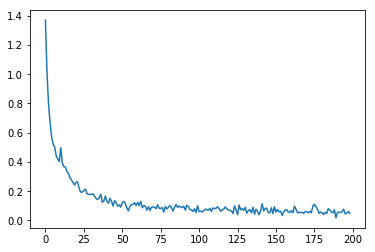

In [45]:
plt.figure()
plt.plot(model_training.losses)

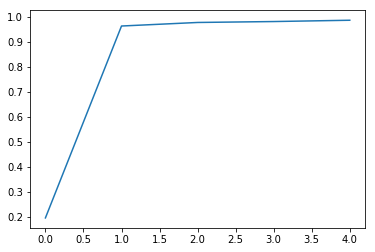

In [46]:
plt.figure()
plt.plot(model_training.accuracy)

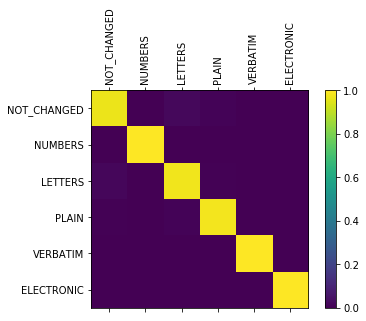

Accuracy: 98.56% (   49281/   50000)
CPU times: user 10min 53s, sys: 4.02 s, total: 10min 57s
Wall time: 2min 45s


In [47]:
%%time
plot_category_confusion_matrix(model, categories_all, test_model_single_sample, n_confusion=50000)

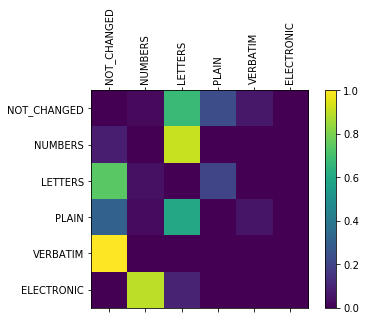

Accuracy: 98.65% (   49324/   50000)
CPU times: user 10min 49s, sys: 4.19 s, total: 10min 53s
Wall time: 2min 44s


In [48]:
%%time
plot_category_confusion_matrix(model, categories_all, test_model_single_sample,
                               n_confusion=50000, remove_diagonal=True)

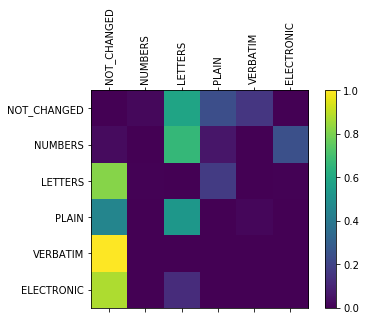

Accuracy: 98.77% (   49386/   50000)
CPU times: user 12min 30s, sys: 5.68 s, total: 12min 35s
Wall time: 3min 18s


In [53]:
%%time
plot_category_confusion_matrix(model, categories_all, test_model_single_sample,
                               n_confusion=50000, remove_diagonal=True)